<a href="https://colab.research.google.com/github/kamijoseph/Steel-Industry-Energy-Consumption/blob/main/steel_energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# steel industries energy consumption

In [46]:
#!pip install joblib xgboost lightgbm catboost

## dependencies

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

## dataset

In [48]:
# display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [49]:
# loading the data
data = pd.read_csv("/content/Steel_industry_data.csv")
data.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [50]:
data.shape

(35040, 11)

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [52]:
# checking for missing values
data.isnull().sum()

,0
date,0
Usage_kWh,0
Lagging_Current_Reactive.Power_kVarh,0
Leading_Current_Reactive_Power_kVarh,0
CO2(tCO2),0
Lagging_Current_Power_Factor,0
Leading_Current_Power_Factor,0
NSM,0
WeekStatus,0
Day_of_week,0


In [53]:
data.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


In [54]:
data.columns.tolist()

['date',
 'Usage_kWh',
 'Lagging_Current_Reactive.Power_kVarh',
 'Leading_Current_Reactive_Power_kVarh',
 'CO2(tCO2)',
 'Lagging_Current_Power_Factor',
 'Leading_Current_Power_Factor',
 'NSM',
 'WeekStatus',
 'Day_of_week',
 'Load_Type']

In [55]:
# converting date into date-time
data["date"] = pd.to_datetime(data["date"], dayfirst=True)

In [56]:
data.head(10)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load
5,2018-01-01 01:30:00,3.28,3.56,0.0,0.0,67.76,100.0,5400,Weekday,Monday,Light_Load
6,2018-01-01 01:45:00,3.60,4.14,0.0,0.0,65.62,100.0,6300,Weekday,Monday,Light_Load
7,2018-01-01 02:00:00,3.60,4.28,0.0,0.0,64.37,100.0,7200,Weekday,Monday,Light_Load
8,2018-01-01 02:15:00,3.28,3.64,0.0,0.0,66.94,100.0,8100,Weekday,Monday,Light_Load
9,2018-01-01 02:30:00,3.78,4.72,0.0,0.0,62.51,100.0,9000,Weekday,Monday,Light_Load


In [57]:
data["Day_of_week"].value_counts()

,count
Day_of_week,
Monday,5088
Tuesday,4992
Wednesday,4992
Thursday,4992
Friday,4992
Saturday,4992
Sunday,4992


In [58]:
# extracting features
data["hour"] = data["date"].dt.hour
data["day"] = data["date"].dt.day
data["month"] = data["date"].dt.month
data["year"] = data["date"].dt.year
data["is_weekend"] = data["Day_of_week"].isin(["saturday", "Sunday"]).astype(int)

In [59]:
# dropping original date
data = data.drop("date", axis=1)
data.columns.tolist()

['Usage_kWh',
 'Lagging_Current_Reactive.Power_kVarh',
 'Leading_Current_Reactive_Power_kVarh',
 'CO2(tCO2)',
 'Lagging_Current_Power_Factor',
 'Leading_Current_Power_Factor',
 'NSM',
 'WeekStatus',
 'Day_of_week',
 'Load_Type',
 'hour',
 'day',
 'month',
 'year',
 'is_weekend']

In [72]:
# checking for outliers
def detect_outliers(data, multiplier=1.5):
  num_features = data.select_dtypes(include=np.number).columns
  summary = []
  outlier_indices = set()

  for feature in num_features:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier + IQR

    # outiler indices
    outliers = data[
        (data[feature] < lower_bound) | (data[feature] > upper_bound).index
    ]
    outlier_indices.update(outliers)

    # appending summary info
    summary.append({
        "Feature": feature,
        "Outlier_Count": len(outliers),
        "Percentage": round(
            (len(outliers) / len(data)) * 100, 2
        )
    })

  # creating a summary dataframe
  outlier_summary = pd.DataFrame(summary).sort_values(
      by = "Outlier_Count",
      ascending = False
  )

  return outlier_summary

## insights:
  - data has no missing values
  - data has no duplicates
  - extracted time based features  from the date (is_weekend is a binary feature)
  - data has a mix of categorical and numerical features (encode categorical features)

In [60]:
# encoding categorical features
cat_features = ["WeekStatus", "Day_of_week", "Load_Type"]

for feature in cat_features:
  encoder = LabelEncoder()
  data[feature] = encoder.fit_transform(data[feature])

In [61]:
data.head(10)

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,hour,day,month,year,is_weekend
0,3.17,2.95,0.0,0.0,73.21,100.0,900,0,1,0,0,1,1,2018,0
1,4.00,4.46,0.0,0.0,66.77,100.0,1800,0,1,0,0,1,1,2018,0
2,3.24,3.28,0.0,0.0,70.28,100.0,2700,0,1,0,0,1,1,2018,0
3,3.31,3.56,0.0,0.0,68.09,100.0,3600,0,1,0,1,1,1,2018,0
4,3.82,4.50,0.0,0.0,64.72,100.0,4500,0,1,0,1,1,1,2018,0
5,3.28,3.56,0.0,0.0,67.76,100.0,5400,0,1,0,1,1,1,2018,0
6,3.60,4.14,0.0,0.0,65.62,100.0,6300,0,1,0,1,1,1,2018,0
7,3.60,4.28,0.0,0.0,64.37,100.0,7200,0,1,0,2,1,1,2018,0
8,3.28,3.64,0.0,0.0,66.94,100.0,8100,0,1,0,2,1,1,2018,0
9,3.78,4.72,0.0,0.0,62.51,100.0,9000,0,1,0,2,1,1,2018,0


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 15 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             35040 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   CO2(tCO2)                             35040 non-null  float64
 4   Lagging_Current_Power_Factor          35040 non-null  float64
 5   Leading_Current_Power_Factor          35040 non-null  float64
 6   NSM                                   35040 non-null  int64  
 7   WeekStatus                            35040 non-null  int64  
 8   Day_of_week                           35040 non-null  int64  
 9   Load_Type                             35040 non-null  int64  
 10  hour                                  35040 non-null  int32  
 11  day            

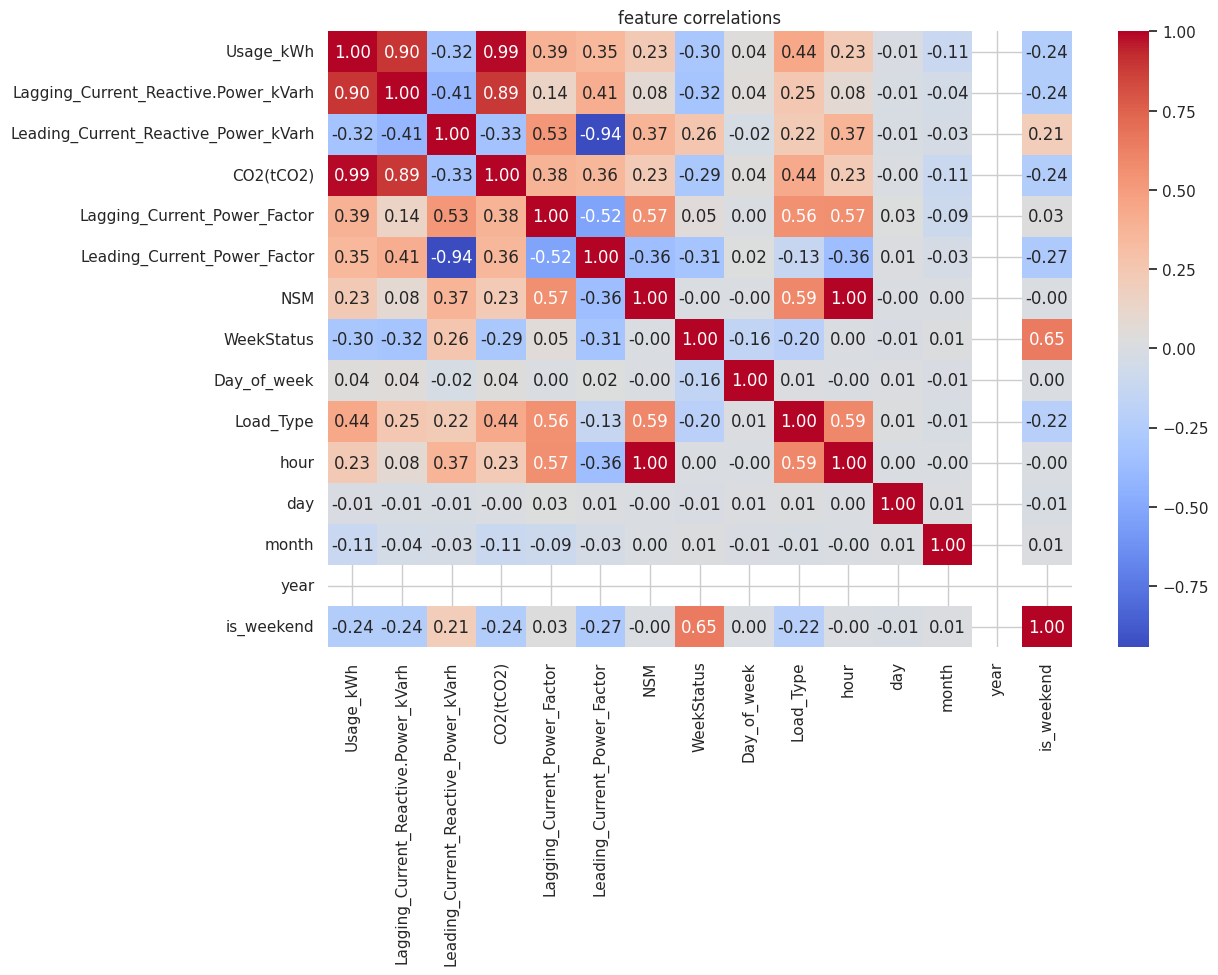

In [70]:
# correlation
corr = data.corr()

# correlation hetmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm"
)
plt.title("feature correlations")
plt.show()

In [63]:
# tfeatures and labels selection
X, y = data.drop(columns=["Usage_kWh"]), data["Usage_kWh"]
X.shape

(35040, 14)

In [65]:
# training and testin data splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 21
)
print(X.shape, X_train.shape, X_test.shape)

(35040, 14) (28032, 14) (7008, 14)
